## Kaggle - 泰坦尼克号




Kaggle 链接： [Titanic: Machine Learning from Disaster](https://www.kaggle.com/c/titanic)



这虽然是一个入门级别的任务，但完整做完后可以学到以下技巧：

1. 如何处理缺失数据
2. 数据预处理流程
3. 如何处理连续值的属性
4. 如何处理离散值的属性

另外，还可以实践一下机器学习任务一般流程：

1. 搞清楚问题的定义
2. 获取数据
3. 分析、清洗数据
4. 建模尝试解决这些问题
5. 优化模型，并完成技术报告

In [1]:
# 数据分析
import pandas as pd
import numpy as np

# 可视化
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## 获取数据

1992 年 Titanic 号在大西洋中不幸撞上冰山，数小时候沉入海底。Titanic 号上乘客和工作人员一共  2224 人，其中 1502 人丧生。这个数据集中包含了部分乘客的相关信息，目的是训练一个二分类器，来根据乘客的相关信息判断该乘客是否存活。这里使用的数据可以从 Kaggle 下载到。

In [2]:
train = pd.read_csv('../data/titanic/train.csv')
test = pd.read_csv('../data/titanic/test.csv')
train_clone = train.copy(deep=True)

## 观察数据

获取到数据后，首先需要观察数据，对数据建立一个初步的认识。明确样本中有哪些特征，各个特征的含义，数据有没有缺失，等等。

In [3]:
train.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


每一行表示一个样本，在这里就是一个乘客的信息。每一列是样本的一项特征，在这里每个样本有 12 个特征，其含义如下：
    
- PassengerId: 乘客的编号
- Survived: 是否存活
- Pclass: 船舱等级，取值范围 1,2,3
- Name: 姓名
- Sex: 性别
- Age: 年龄
- SibSp: 兄弟姐妹数量
- Parch: 父母和孩子数量
- Ticket: 船票编号
- Fare: 票价
- Cabin: 船舱号
- Embarked: 登船的港口，泰坦尼克号在不同的港口停靠，不同的港口都有乘客登船 (C=Cherbourg, Q=Queenstown, S=Southampton)



In [4]:
print(train.info())
print("-" * 40)
print(test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            332 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non

使用 `info()` 方法可以从整体上对数据建立一些认识，可以知道数据有多少行，每个属性的数据类型，是否存在缺失值。从上面结果看出，训练集中有 891 个样本，其中 `Age`, `Cabin`, `Embarked` 三个属性存在缺失值。测试集中 Age Fare Cabin 三个属性存在缺失值。

## 分析数据

样本中 `PassengerId`, `Ticket` 和 `Cabin` 在此处感觉都没有用的信息，因为虽然船票编号和船舱编号可能决定船舱位置，但已经有相应的字段来说明这些隐含的信息了，所以决定去除这三个字段。

### 幸存比例

训练数据显示，只有 38.4% 的人幸存。即有 61.6% 的人丧生，因此我们的模型就算预测所有人的丧生，也能得到越 61% 的准确率。

In [5]:
train['Survived'].mean()

0.3838383838383838

### Sex

观察性别与存活与否的关系：

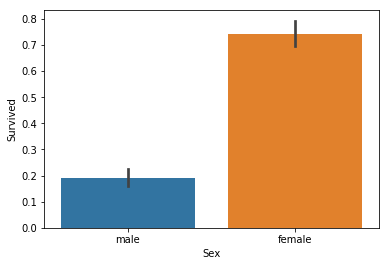

In [6]:
sns.barplot(x='Sex',y='Survived',data=train)

可见，性别与幸存率有很大关系。

### Age

年龄是连续值，不适合直接作为特征，需要将将其分段，划分为不同年龄的范围。这里我们将年龄划分为 5 个段，大约 15 岁一个段比较合适。

In [7]:
train['Age'].min(), train['Age'].max()

(0.42, 80.0)

In [8]:
train['AgeGroup'] = pd.cut(train['Age'], bins=[0, 15, 30, 45, 60, np.inf], labels=range(5))
train['AgeGroup'].value_counts()

1    326
2    202
0     83
3     81
4     22
Name: AgeGroup, dtype: int64

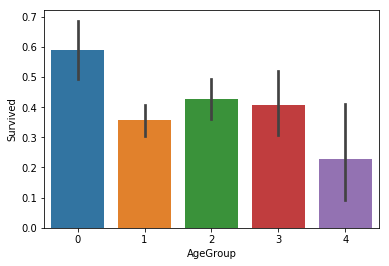

In [9]:
sns.barplot(x='AgeGroup',y='Survived',data=train)

不同年龄段的幸存率存在差异，老年人幸存率很低，小孩幸存率则相对高一些。

### Pclass

船舱等级（Pclass）可取值为：

- 1 (Upper)
- 2 (Middle) 
- 3 (Lower)


船舱等级对幸存与否有很大影响，船舱的等级可能和距离甲板的距离有关，而距离甲板越近的船舱越有机会逃生。

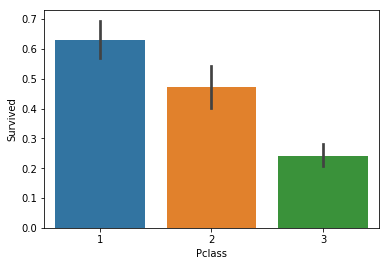

In [10]:
sns.barplot(x='Pclass',y='Survived',data=train)

可见船舱等级（Pclass）确实对幸存与否影响很大，不同船舱等级对应的幸存率有明显差异。

### Fare

票价也是连续值，需要将其分桶，转为价格区间，可以先观察一下票价分布情况：

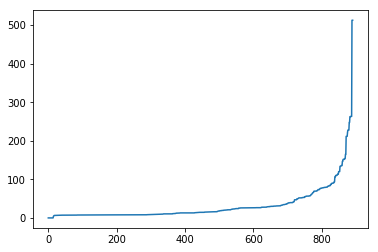

In [11]:
Fare = np.sort(train['Fare'].values)
plt.plot(Fare)

从上图可以看出，票价主要分布在 100 以内，划分 6 个段：

```
0  - 20
20 - 40
40 - 60
60 - 80
80 -
```

In [12]:
train['FareGroup'] = pd.cut(train['Fare'], bins=[0, 20, 40, 60, 80, np.inf] , labels=range(5))

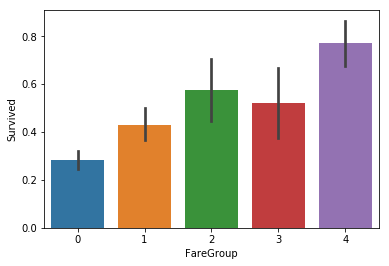

In [13]:
sns.barplot(x='FareGroup', y='Survived', data=train)

### Embarked

泰坦尼克号行驶路线是从英国南安普敦出发，途经法国瑟堡奥克特维尔以及爱尔兰科夫，驶向美国纽约，乘客是从不同的港口登船的。Embarked 的取值有三种：

- C (Cherbourg) 瑟堡（法国西北部港市）
- Q (Queenstown) 昆斯敦（新西兰）
- S (Southampton) 南安普敦（英国英格兰南部港市）

感觉登船的位置和是否幸存没啥关系，但是统计了一下发现，不同地方登船的乘客，幸存率存在差异。我估计可能是登船港口和船舱位置有关。

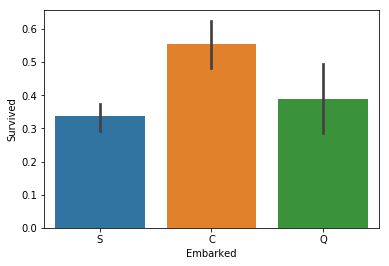

In [14]:
sns.barplot(x='Embarked',y='Survived',data=train)

### SibSp 和 Parch

兄弟姐妹数量（SibSp）和父母与孩子数量（Parch）可以统一称为家庭成员数量。家庭规模的大小，可能影响是否幸存。另外是否一个人独自乘船，也可能和幸存与否有关。

In [15]:
train['FamilySize'] = train[['SibSp', 'Parch']].sum(axis=1) + 1 # 加上自己
train['Alone'] = train['FamilySize'] == 1

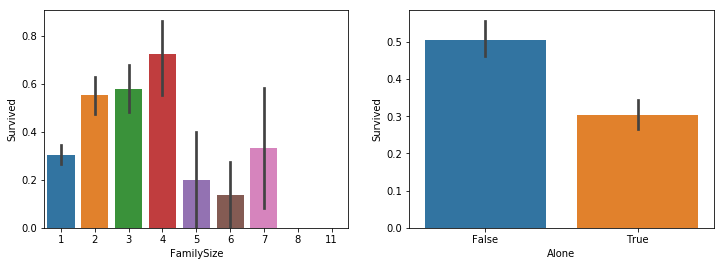

In [16]:
plt.figure(figsize=(12,4))
plt.subplot(121)
sns.barplot(x='FamilySize',y='Survived',data=train)
plt.subplot(122)
sns.barplot(x='Alone',y='Survived',data=train)

家庭成员数量和幸存率有关，独自一人乘船幸存率较低。

### Name

姓名看似和幸存没有关系，但这里 Name 并不只是乘客的名字，还包含了头衔。比如 Mrs. Miss. 等，这能体现乘客的某些特征。这里可以将乘客的头衔抽取出来。

In [17]:
train['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

In [18]:
import re

def get_title(name):
    r_title = re.search(' ([A-Za-z]+)\.', name)
    if not r_title:
        return ""
    
    return r_title.group(1)

train['Title'] = train['Name'].apply(get_title)

In [19]:
train['Title'].value_counts()

Mr          517
Miss        182
Mrs         125
Master       40
Dr            7
Rev           6
Col           2
Mlle          2
Major         2
Capt          1
Don           1
Sir           1
Ms            1
Jonkheer      1
Countess      1
Lady          1
Mme           1
Name: Title, dtype: int64

可以把出现次数较少的头衔归为一个类别：

In [20]:
rare_mask = train['Title'].isin(['Mr','Miss','Mrs','Master']) == False
train['Title'][rare_mask] = 'Rare'
train['Title'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
Rare       27
Name: Title, dtype: int64

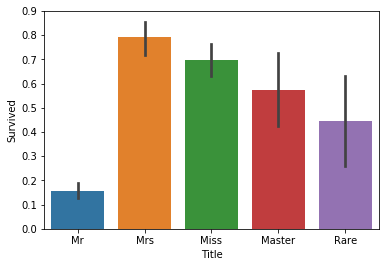

In [21]:
sns.barplot(x='Title', y='Survived', data=train)

## 预处理数据

之前的步骤中，对数据有了初步认识，了解了样本特征和问题的关联程度。接下来就需要对数据进行预处理，便于下一步训练分类模型。这包括一下几个步骤：

1. 对缺失值进行填充
2. 添加新的特征，比如是否独自乘船
3. 对连续值，如年龄、票价，进行分段
4. 将枚举值转换为 one-hot 编码的向量

### 填充缺失值

前面已经分析过，Age, Cabin, Embarked，Fare 三个属性存在缺失值。Cabin 是船舱号，此处抛弃这个属性。因此需要对 Age 和 Embarked 属性中缺失的值进行填充。

**填充 Age**

有 177 个乘客的详细年龄缺失，缺失比例还是很大的，需要想办法尽可能合理的对 Age 进行填充。

In [22]:
train[np.isnan(train['Age'])].shape

(177, 17)

从乘客 Title 中，大致推断年龄。比如 Miss 应该是 20 岁左右的女士。这里根据乘客的 Title 对缺失年龄进行填充，使用正太分布随机数填充，各个 Title 对应的年龄均值和标准差可以使用 `describe()` 得到：

In [23]:
mean_std_info = train.groupby('Title')['Age'].describe()[['mean','std']].T.to_dict()
mean_std_info

{'Master': {'mean': 4.574166666666667, 'std': 3.6198716433439615},
 'Miss': {'mean': 21.773972602739725, 'std': 12.99029242215268},
 'Mr': {'mean': 32.368090452261306, 'std': 12.70879272257399},
 'Mrs': {'mean': 35.898148148148145, 'std': 11.433627902196413},
 'Rare': {'mean': 42.38461538461539, 'std': 13.200233098174964}}

In [24]:
def fill_age(title):
    mean = mean_std_info[title]['mean']
    std = mean_std_info[title]['std']
    return np.random.normal(mean, std)

train['Age'][np.isnan(train['Age'])] = train['Title'][np.isnan(train['Age'])].apply(fill_age)

**填充 Embarked**

Embarked 只有 2 个存在缺失，那就直接使用出现最多的 S 来填充。

In [25]:
print(train['Embarked'].isna().sum())
train['Embarked'].value_counts()

2


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [26]:
train['Embarked'].fillna('S', inplace=True)

**填充 Fare**

测试集中 Fare 存在一个缺失值，使用 Fare 的均值进行填充即可。

In [27]:
test['Fare'].fillna(test['Fare'].mean(), inplace=True)

### one-hot 编码

经过上面的处理步骤后，每个乘客的属性都变成了枚举值，还需要在将其向量化。比如 Pclass 有 1,2,3 三种取值，但数字的大小并没有什么意义。不过在使用如 Logistics Regression 这样的线性模型时，因为模型要计算 `wx+b`，这样数字大小就有意义了。为此，在这里需要将所有枚举值转为 one-hot 编码的向量。

```
1 -> [1 0 0]
2 -> [0 1 0]
3 -> [0 0 1]
```

这样 Pclass 属性就使用一个三维的向量表示，其他的枚举属性也这样处理。

对枚举值做 one-hot 编码，可以使用 pandas.du

### 整合全部过程

经过前面的分析，已经明确了下面几点：

- 抛弃与保留那些属性
- 对各个属性如何预处理
- 新增那些属性
- 对缺失值如何处理
- 如何对枚举值进行编码

我们需要将以上步骤整合起来，写在一个函数里。

In [28]:
def process(dataset):
    # 填充缺失值
    dataset['Fare'].fillna(dataset['Fare'].mean(), inplace=True)
    dataset['Embarked'].fillna('S', inplace=True)
    
    # 新增 Title
    def get_title(name):
        r_title = re.search(' ([A-Za-z]+)\.', name)
        if not r_title:
            return ""
        return r_title.group(1)
    
    dataset['Title'] = dataset['Name'].apply(get_title)
    rare_mask = dataset['Title'].isin(['Mr','Miss','Mrs','Master']) == False
    dataset['Title'][rare_mask] = 'Rare'
    
    # 填充缺失 Age
    def fill_age(title):
        mean = mean_std_info[title]['mean']
        std = mean_std_info[title]['std']
        return np.random.normal(mean, std)

    dataset['Age'][np.isnan(dataset['Age'])] = dataset['Title'][np.isnan(dataset['Age'])].apply(fill_age)
    
    # 新增属性
    dataset['AgeGroup'] = pd.cut(dataset['Age'], bins=[-np.inf, 15, 30, 45, 60, np.inf], labels=range(5))
    dataset['FareGroup'] = pd.cut(dataset['Fare'], bins=[-np.inf, 20, 40, 60, 80, np.inf], labels=range(5))
    dataset['FamilySize'] = dataset[['SibSp', 'Parch']].sum(axis=1) + 1
    dataset['Alone'] = dataset['FamilySize'] == 1
    
    # 选择需要的属性
    attrs = ['Pclass', 'Sex', 'Embarked', 'AgeGroup', 'FareGroup', 'FamilySize', 'Alone', 'Title']
    dataset = dataset[attrs]

    # 把数值型属性转为字符型，便于做 one-hot 编码
    dataset[['Pclass', 'FamilySize']] = dataset[['Pclass', 'FamilySize']].astype(np.str)

    return dataset
    
train_processed = process(train_clone)
test_processed = process(test)

In [29]:
print(train_processed.info())
print("-" * 40)
print(test_processed.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
Pclass        891 non-null object
Sex           891 non-null object
Embarked      891 non-null object
AgeGroup      891 non-null category
FareGroup     891 non-null category
FamilySize    891 non-null object
Alone         891 non-null bool
Title         891 non-null object
dtypes: bool(1), category(2), object(5)
memory usage: 37.6+ KB
None
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
Pclass        418 non-null object
Sex           418 non-null object
Embarked      418 non-null object
AgeGroup      418 non-null category
FareGroup     418 non-null category
FamilySize    418 non-null object
Alone         418 non-null bool
Title         418 non-null object
dtypes: bool(1), category(2), object(5)
memory usage: 17.8+ KB
None


### 得到训练数据

前面的步骤中对填充了缺失数据，新增了部分属性，将连续值划分成了不同的段。但没有做 one-hot 编码。某个属性的值，可以在训练集中没有出现，但是出现在了测试集中。这个时候 one-hot 编码的时候，就会出现问题。所以在进行 one-hot 编码的时候，一定要知道能够应对这种问题。

这里我将训练数据和测试数据合并起来，这样就能得知每个属性的所有可取值，然后利用 sklearn 的 `OneHotEncoder` 来完成 one-hot 编码。

In [31]:
from sklearn.preprocessing import OneHotEncoder

dataset = pd.concat([train_processed, test_processed], axis=0)

one_hot = OneHotEncoder()
one_hot.fit(dataset)

X_train = one_hot.transform(train_processed)
X_test = one_hot.transform(test_processed)

y_train = train_clone['Survived'].values

# 把训练数据打乱
index = np.random.permutation(X_train.shape[0])
X_train = X_train[index]
y_train = y_train[index]

## 训练分类器

得到了训练数据之后，就可以开始训练模型了，这里一次性尝试多种常见分类器，使用默认的配置项。

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier

from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

In [33]:
svc = SVC()
bnb = BernoulliNB()
lrc = LogisticRegression()
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
abc = AdaBoostClassifier(n_estimators=100, random_state=42)
bc = BaggingClassifier(n_estimators=100, random_state=42)
etc = ExtraTreesClassifier(n_estimators=100, random_state=42)

clfs = [svc, bnb, lrc, rfc, abc, bc, etc]

为了评估分类器的效果，一种做法是从训练数据中划出一部分数据作为验证集。不过为了得到较准确评估结果，往往需要多次划分训练集和验证集，取均值。sklearn 中的 `cross_val_score` 可以帮助我们完成此工作。

In [34]:
from time import time

for clf in clfs:
    start = time()
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()
    duration = time() - start
    clf_name = clf.__class__.__name__
    
    print("{} - {:.2%} - {:.2f}s".format(clf_name, score, duration))

SVC - 82.15% - 0.27s
BernoulliNB - 79.12% - 0.03s
LogisticRegression - 81.70% - 0.03s
RandomForestClassifier - 80.13% - 1.22s
AdaBoostClassifier - 81.36% - 0.98s
BaggingClassifier - 80.02% - 2.57s
ExtraTreesClassifier - 80.02% - 1.13s


从以上结果可以看出，除了朴素贝叶斯模型外，其他模型都能得到 81% 以上的准确度。下一步可以尝试对各个模型的参数进行调整，找出各个模型的最佳参数。

### 优化模型参数

这里以随机森林分类器为例，使用 GridSearch 来搜索最佳参数。

In [35]:
from sklearn.model_selection import GridSearchCV

random_forest = RandomForestClassifier()

param_grid = [{
    'n_estimators': [40, 50, 70, 100],
    'max_depth': [3, 4, 5, 6, 8],
    'min_samples_leaf': [1, 2, 3]
}]

grid_search = GridSearchCV(random_forest, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

_ = grid_search.fit(X_train, y_train)

In [36]:
grid_search.best_score_, grid_search.best_params_

(0.8282828282828283,
 {'max_depth': 5, 'min_samples_leaf': 3, 'n_estimators': 40})

可以看到调优后的随机森林分类器得到了 82.9% 的最准确率。

### 多分类器集成

中国有谚语：“三个臭皮匠赛过诸葛亮”，对同一个样本多个分类器可能给出不同的预测结果，多个分类器投票觉得结果，往往更加可靠。因为每个分类器在分类的时候的依据往往是不同的，有的从空间上来划分，有的从概率分布上来决定。综合多种分类器的分类结果，常常能够取得更佳的效果。

但是如果分类器都是同种类型的，这就相当于在投票的群体中有一部分是一伙的，他们常常倾向于给出相同的投票结果，因此在投票的时候应该避免使用同类的分类器。

使用 sklearn 中 VotingClassifier 分类器，可以轻松完成这个投票过程：

In [37]:
from sklearn.ensemble import VotingClassifier

svc = SVC(C=0.3, degree=2, kernel='linear', probability=True)
lrc = LogisticRegression(C=0.8, penalty='l1')
# rfc = RandomForestClassifier(n_estimators=40, max_depth=5)
abc = AdaBoostClassifier(n_estimators=60)
bc = BaggingClassifier(n_estimators=50, bootstrap_features=True, max_features=0.9, max_samples=0.9)
# etc = ExtraTreesClassifier(n_estimators=100)

clfs = [svc, lrc, abc, bc]

eclf = VotingClassifier(estimators=[
    (clf.__class__.__name__, clf) for clf in clfs
], voting='hard')

cross_val_score(eclf,  X_train, y_train, cv=5, n_jobs=-1).mean()

0.8282130175080601

分类器能够输出分类的概率，如果分类为正的概率为 0.9 就说明比较确信。如果分类为 0.5 则说明模棱两可。如果在某次决策中，其他分类器都给出了 0.49 的概率，只有一个分类器给出了 0.99 的概率。这说明在大家都不太确定的时候，其中有一个分类器非常确信，此次投票就可以听他的。

这种策略就是软投票，将各个分类器输出的概率求均值，然后判断概率是否大于 0.5，大于就是正，否则为负。

In [38]:
eclf = VotingClassifier(estimators=[
    (clf.__class__.__name__, clf) for clf in clfs
], voting='soft')

cross_val_score(eclf,  X_train, y_train, cv=5, n_jobs=-1).mean()

0.8315901520221207

使用 `cross_val_score` 只是评估了模型的效果，它 clone 了原模型，并多次交叉验证。要得到可以进行预测的模型，需要使用全部的数据进行训练。

In [39]:
eclf.fit(X_train, y_train)

VotingClassifier(estimators=[('SVC', SVC(C=0.3, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=2, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)), ('LogisticRegression', LogisticRegressio...imators=50, n_jobs=None, oob_score=False, random_state=None,
         verbose=0, warm_start=False))],
         flatten_transform=None, n_jobs=None, voting='soft', weights=None)

## 预测

预测并保存结果，上传结果至 Kaggle。

In [40]:
y_pred = eclf.predict(X_test)

submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": y_pred
})

submission.to_csv("../data/titanic/submission.csv", index=False)

提交到 Kaggle 上之后得分 0.78947。